#This Project is developed to take a wav file of a single voice of music and get the musical pitch at any time frame.

Imports:

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import statistics
import random
import math
import librosa
import json

Name of User (used in application)

In [213]:
userId = 'user'

ONLY SET TO TRUE DURING TESTING: graphs every segment of audio (largely increases run time)

In [214]:
fullgraph = False

Load audio file (only accepts .wav file)

In [215]:
fileName = "sample7.wav"
originalFileLoc = "./data/raw/" + fileName
x, sr = librosa.load(originalFileLoc)
audioDuration = librosa.get_duration(y=x, sr=sr)

Set values

In [216]:
#What decimal to round time / signal too
defaultDecimalRate = 5
#Rate to lower bit by
defaultLoweringRate = 3
#How long each frequency reading should be (in seconds)
defaultDurationTime = 0.05
#Percent of each relative max/min to keep
percentAcceptable = 0.8
#Perecent difference to check for double relative max/mins
percentDoubles = 0.75
#Percent difference in frequencies to stil accept
acceptableFreqPercent = 0.95

defaultMinDist = defaultDurationTime

pitchToLetter = {
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

pitches = {0: 65.406}
currentPitch = 0
while currentPitch <= 71:
    prevPitch = pitches[currentPitch]
    currentPitch += 1            
    pitches[currentPitch] = prevPitch * (2 ** (1/12))

(optional) show audio file for comparison (musicSample.png for demo)

In [217]:
# music file = musicSample.png
timeListSample = [0, 2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16]
pitchListSample = [14, 14, 16, 16, 18, 18, 19, 19, 21, 21, 23, 23, 25, 25, 26, 26]

gradingDictSample = {}
for i in range(len(timeListSample) // 2):
    gradingDictSample[timeListSample[i * 2]] = {
        "startTime": timeListSample[i * 2],
        "pitchClass": pitchListSample[i * 2],
        "endTime": timeListSample[(i * 2) + 1]
    }


Get notes from freq

In [218]:
def freqToNotes(freqList):
    retFreqList = []
    for x in freqList:
        if (x >= 65.406):
            retFreqList.append((12 * math.log((500 * x) / 32523)) / (math.log(2)))
        else: 
            retFreqList.append(-1)
    return retFreqList

Create Functions

In [219]:
def is_close(a, b, tolerance=1e-2):
       return abs(a - b) < tolerance

def lowerRate(lst, rte, decimalRate):
    """(List of signal, updated rate (x))
    Used to lower bitrate by a factor of x to fix fuzz"""
    retList = []
    for i in range(int(len(lst) / rte) - 1):
        includedIndices = [lst[i * rte]]
        for j in range(rte):
            includedIndices.append(lst[(i * rte) + j + 1])
        retList.append(round(statistics.median(includedIndices),decimalRate))
    return (retList)

Pitch Analyzer Class:

In [ ]:

class PitchAnalyzer:
    def __init__(self, filename, decimalRate = defaultDecimalRate, loweringRate = defaultLoweringRate, minDist = defaultMinDist, durationTime = defaultDurationTime):
        self.decimalRate = decimalRate
        self.loweringRate = loweringRate
        self.minDist = minDist
        self.durationTime = durationTime
        self.freqDict = {}
        
        
        spf = wave.open(filename, "r")
        signal = spf.readframes(-1)
        signal = np.frombuffer(signal, np.int16)
        
        frameRate = spf.getframerate()
        
        timeList = []
        
        newDuration = (len(signal) / frameRate)
        if is_close(newDuration / 2, audioDuration): 
            for i in range(len(signal)):
                timeList.append(round((i / 2) / frameRate,self.decimalRate))
                
        else:
            for i in range(len(signal)):
                timeList.append(round(i / frameRate,self.decimalRate))
                

        
        
        
            
        if self.loweringRate != 1:
            signal = lowerRate(signal, self.loweringRate, self.decimalRate)
            timeList = lowerRate(timeList, self.loweringRate, self.decimalRate)
            
            
        self.signal = signal.copy()
        self.timeList = timeList.copy()
        self.length = timeList[-1]
        
    def createWavGraph(self, fileLoc):
        
        plt.figure(1)
        plt.title("Musical Plot of: " + fileLoc)
        plt.plot(self.timeList, self.signal)
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()

        # plt.savefig('my_plot.png')
        
    def gradeSelf(self, gradingDict):
        
        #Grade by (weighed median towards lower grade / classic median)
        
        noteGradeList = []
        for i in gradingDict:
            currentGradedDict = gradingDict[i]
            
            userPitchList = []
            currentTime = currentGradedDict["startTime"]
            while currentTime <= currentGradedDict["endTime"]:
                currentTime = round(currentTime, defaultDecimalRate)
                if currentTime in self.freqDict:
                    userPitchList.append(self.freqDict[currentTime]['pitchClass'] + self.freqDict[currentTime]['cents_innacurate'])
                currentTime += defaultDurationTime
            
            pitchDifferenceList = []
            for j in userPitchList:
                pitchDifferenceList.append((j - currentGradedDict["pitchClass"]) ** 2)
            
            medianSquareError = statistics.median(pitchDifferenceList)
            noteGradeList.append(medianSquareError)
            
        retGrade = 100.0
        totalNotes = len(noteGradeList)
        for i in noteGradeList:
            thisGrade = i
            if thisGrade >= 1:
                thisGrade = 1
            retGrade -= thisGrade * (100/totalNotes)
            
            
        return(retGrade, noteGradeList)
            
        
    
    def graphPitches(self, fileLoc):
        retFreqList = []
        retTimeList = []
        
        i = 0
        
        while i < self.length - 0.1:
            try:
                if fullgraph == False:
                    retFreqList.append(self.getPitchAtTime(i))
                if fullgraph == True:
                    retFreqList.append(self.getPitchAtTime(i, fileName = ("./data/processed/plotPartial/plot[t=" + str(round(i, defaultDecimalRate)) + "-" + str(round(i + self.durationTime, defaultDecimalRate)) + "]" + userId + ".png")))
                    print("Completed t=" + str(i) + "-" + str(i + self.durationTime))
                retTimeList.append(i)
            except Exception as err:
                print(err)
                pass

            i += self.durationTime
        
        # while i < self.length - 0.1:
        #     if fullgraph == False:
        #         retFreqList.append(self.getPitchAtTime(i))
        #     if fullgraph == True:
        #         retFreqList.append(self.getPitchAtTime(i, fileName = ("./data/processed/plotPartial/plot[t=" + str(i) + "-" + str(i + self.durationTime) + "]" + userId + ".png")))
        #         print("Completed t=" + str(i) + "-" + str(i + self.durationTime))
        #     retTimeList.append(i)

        #     i += self.durationTime
            
        
        
        if fullgraph == False: 
            specTimeLoc = retTimeList[random.randint(0,len(retTimeList) - 1)]
            self.getPitchAtTime(specTimeLoc, fileName = ("./data/processed/plotPartial" + userId + ".png"))
            
        self.createWavGraph(fileLoc = ("./data/processed/plotFull" + userId + ".png"))
        
            
        # avgVal = statistics.median(retFreqList)
        # removeIndexes = []
        # for i in range(len(retFreqList)):
        #     currentVal = retFreqList[i]
        #     if not (currentVal) < (avgVal * (1 + (self.minDist * 10))) and (currentVal) > (avgVal * (1 - (self.minDist * 0.1))):
        #         removeIndexes.append(i)
                
        # retFreqList = [item for index, item in enumerate(retFreqList) if index not in removeIndexes]
        # retTimeList = [item for index, item in enumerate(retTimeList) if index not in removeIndexes]

        retFreqList = freqToNotes(retFreqList)
        
        # retFreqList = lowerRate(retFreqList, 5, self.decimalRate)
        # retTimeList = lowerRate(retTimeList, 5, self.decimalRate)

        timeFreqDict = {}
        for i in range(len(retTimeList)):
            currentPitchClass = retFreqList[i]
            currentNoteName = round(currentPitchClass, 0)
            currentNoteCents = currentPitchClass - currentNoteName
            currentNoteName %= 12
            currentNoteName = pitchToLetter[currentNoteName]
            retDict = {
                "pitchClass" : round(currentPitchClass, 0),
                "noteName" : currentNoteName,
                "cents_innacurate" : currentNoteCents,
            }
            timeFreqDict[round(retTimeList[i], defaultDecimalRate)] = retDict
            
        self.freqDict = timeFreqDict
        
        with open("./data/processed/timeFreq.json", "w") as outfile:
            json.dump(timeFreqDict, outfile)

            
        plt.figure(1)
        plt.title("Frequency (hz) over time (seconds)" )
        plt.plot(retTimeList, retFreqList, color = 'blue', label = "Sung Pitches")
        plt.plot(timeListSample, pitchListSample, color = 'red', label = "Correct Pitches")
        
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()
            
        
        
        
         


    def getPitchAtTime(self, startTime, fileName = False, durationTime = False):
        """(Start time in seconds, End time in seconds, name of .wav file)
        Returns most common frequency at the listed time"""
        
        
        
        #MEW IDEA TO GO THROUGH ALL FREQUENCIES IN LIST AND ONLY TAKE SIMILAR ~90% values to lowest value, acceptableFreqPercent variable
        
        if (durationTime == False):
            durationTime = self.durationTime
        
        decimalRate = self.decimalRate
        minDist = self.minDist
        
        startTime = round(startTime, decimalRate)
        durationTime = round(durationTime, decimalRate)
        
        signal = self.signal.copy()
        timeList = self.timeList.copy()
        
        
        

        while(startTime not in timeList):
            startTime = round(startTime + 1 / 10 ** decimalRate,decimalRate)
        startIndex = int(timeList.index(startTime))
        while (startTime + durationTime not in timeList):
            durationTime += 1 / 10 ** decimalRate
            durationTime = round(durationTime, decimalRate)
        endIndex = int(timeList.index(startTime + durationTime))

        signal = signal[startIndex:endIndex]
        timeList = timeList[startIndex:endIndex]
        
        signalAvg = np.max(signal) + np.min(signal)
        signal = signal - (signalAvg / 2)

        peakVals = [signal[0]]
        peakTimes = [timeList[0]]
        for index, i in enumerate(signal):
            j = timeList[index]
            if (abs(i) > abs(peakVals[-1]) and i * peakVals[-1] >= 0):
                peakVals[-1] = i
                peakTimes[-1] = j
            elif (peakVals[-1] * i < 0):
                peakVals.append(i)
                peakTimes.append(j)
                
        ### Remove non global max / mins
        peakValsA = peakVals[::2]
        peakTimesA = peakTimes[::2]
        
        topValA = max(peakValsA, key=abs)
        indexToRemoveA = []
        for i in range(len(peakValsA)):
            if (abs(peakValsA[i]) / abs(topValA)) < percentAcceptable:
                indexToRemoveA.append(i)
                
        for i in sorted(indexToRemoveA, reverse=True):
            del peakValsA[i]
            del peakTimesA[i]
                
        
        peakValsB = peakVals[1::2]
        peakTimesB = peakTimes[1::2]
        
        topValB = max(peakValsB, key=abs)
        indexToRemoveB = []
        for i in range(len(peakValsB)):
            if (abs(peakValsB[i]) / abs(topValB)) < percentAcceptable:
                indexToRemoveB.append(i)
                
        for i in sorted(indexToRemoveB, reverse=True):
            del peakValsB[i]
            del peakTimesB[i]
            
        peakVals = peakValsA + peakValsB
        peakTimes = peakTimesA + peakTimesB
            

        graphVals = []
        for i in range(len(peakVals)):
            graphVals.append([peakVals[i], peakTimes[i]])

        
        signalDerivative = []

        for i in range(len(signal) - 1):
            topNum = signal[i + 1]
            botNum = signal[i]
            signalDerivative.append(topNum - botNum)
            
        prevVal = signalDerivative[0]
        changesOfDerivative = []
        antiPeaks = []
        for i in range(len(signalDerivative) - 1):
            currentVal = signalDerivative[i + 1]
            
            if currentVal * prevVal < 0:
                changesOfDerivative.append(i + 1)

        frequencies = []
        avgFreq = 0
        if len(peakTimes) < 4:
            raise Exception("Not enough max/mins")
        
        peakTimesPos = []
        peakTimesNeg = []
        
        for i in range(len(peakTimes)):
            if peakVals[i] >= 0:
                peakTimesPos.append(peakTimes[i])
            else:
                peakTimesNeg.append(peakTimes[i])
                
        if len(peakTimesPos) < 4:
            raise Exception("Not enough maxs")
        
        if len(peakTimesNeg) < 4:
            raise Exception("Not enough mins")
        
        freqPos = []
        freqNeg = []
        
        minFreq = 1000
        
        for i in range(len(peakTimesPos) - 1):
            topNum = peakTimesPos[i + 1]
            botNum = peakTimesPos[i]
            if topNum != botNum:
                currentFreq = (1/(topNum - botNum))
                if currentFreq < minFreq:
                    minFreq = currentFreq
                if minFreq / currentFreq >= acceptableFreqPercent:
                    freqPos.append(currentFreq)
                
        # freqsA = []
        # freqsB = []
        # for i in range(len(freqPos)):
        #     if i % 2 == 0:
        #         freqsA.append(freqPos[i])
        #     else:
        #         freqsB.append(freqPos[i])
                
        # medianA = statistics.median(freqsA)
        # medianB = statistics.median(freqsB)
        
        # if (medianA >= medianB and medianB / medianA < percentDoubles):
        #     freqPos = freqsB
            
        # elif (medianB >= medianA and medianA / medianB < percentDoubles):
        #     freqPos = freqsA
            
        avgFreqPos = statistics.median(freqPos)
        
        minFreq = 1000
        
        for i in range(len(peakTimesNeg) - 1):
            topNum = peakTimesNeg[i + 1]
            botNum = peakTimesNeg[i]
            if topNum != botNum:
                currentFreq = (1/(topNum - botNum))
                if currentFreq < minFreq:
                    minFreq = currentFreq
                if minFreq / currentFreq >= acceptableFreqPercent:
                    freqNeg.append(currentFreq)
                
        # freqsA = []
        # freqsB = []
        # for i in range(len(freqNeg)):
        #     if i % 2 == 0:
        #         freqsA.append(freqNeg[i])
        #     else:
        #         freqsB.append(freqNeg[i])
                
        # medianA = statistics.median(freqsA)
        # medianB = statistics.median(freqsB)
        
        # if (medianA >= medianB and medianB / medianA < percentDoubles):
        #     freqNeg = freqsB
            
        # elif (medianB >= medianA and medianA / medianB < percentDoubles):
        #     freqNeg = freqsA
            
        avgFreqNeg = statistics.median(freqNeg)
        
        if avgFreqPos < avgFreqNeg:
            avgFreq = avgFreqPos
            removeList = []
            for i in range(len(graphVals)):
                if graphVals[i][0] < 0:
                    removeList.append(i)
            for i in sorted(removeList, reverse=True):
                del graphVals[i]
        else:
            avgFreq = avgFreqNeg
            removeList = []
            for i in range(len(graphVals)):
                if graphVals[i][0] > 0:
                    removeList.append(i)
            for i in sorted(removeList, reverse=True):
                del graphVals[i]
            
        
        if (fileName != False):
        
            plt.figure(1)
            plt.title("Musical Plot of: " + fileName)
            plt.plot(timeList, signal)
            for i in (changesOfDerivative):
                plt.plot(timeList[i], signal[i], 'ro')
                plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
            for i in (graphVals):
                plt.plot(i[1], i[0], 'bo')

            plt.savefig(fileName) 
            if fullgraph == False:
                plt.show()
            plt.close()
        
        return(avgFreq)

Create analyzer

In [221]:
thisAnalyzer = PitchAnalyzer(originalFileLoc)

Graph all pitches

Not enough maxs
Not enough maxs
Not enough maxs
Not enough maxs
Not enough maxs
Not enough max/mins
Not enough max/mins
Not enough max/mins
Not enough maxs
Not enough maxs
Not enough maxs
Not enough max/mins
Not enough max/mins
Not enough max/mins
Not enough max/mins
Not enough max/mins
Not enough maxs
Not enough max/mins
Not enough maxs
Not enough maxs
Not enough maxs
Not enough max/mins
Not enough maxs
Not enough max/mins
Not enough max/mins
Not enough maxs
Not enough maxs


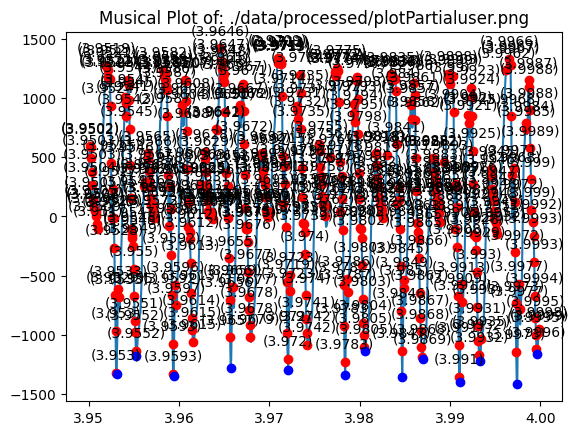

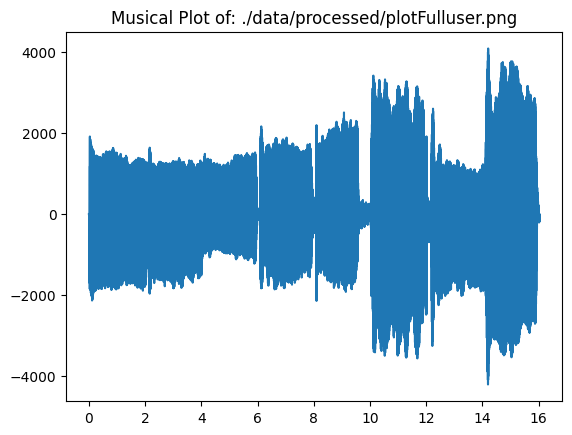

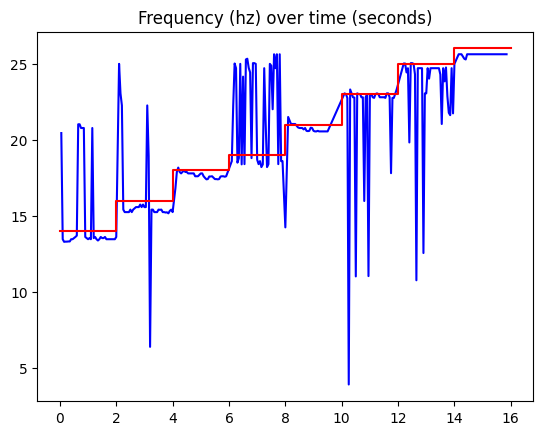

In [222]:
thisAnalyzer.graphPitches("./data/processed/pitchesPlotFull" + userId + ".png")

In [223]:
print(thisAnalyzer.gradeSelf(gradingDictSample))

(99.69635029646338, [0.27801156421421036, 0.5576658617805855, 0.15387450765205649, 16.591953829654777, 0.16756920324467467, 0.041201638039135596, 0.08684786178989468, 0.14402699157229076])
